# GD4. CutMix Mixup Ablation Study

## (1) 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- `stanford_dogs` 데이터셋 : 120개 견종의 이미지 포함, 20580장 이미지에서 12000장은 학습셋, 8580자은 평가용 데이터셋임.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRNWAJL/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRNWAJL/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


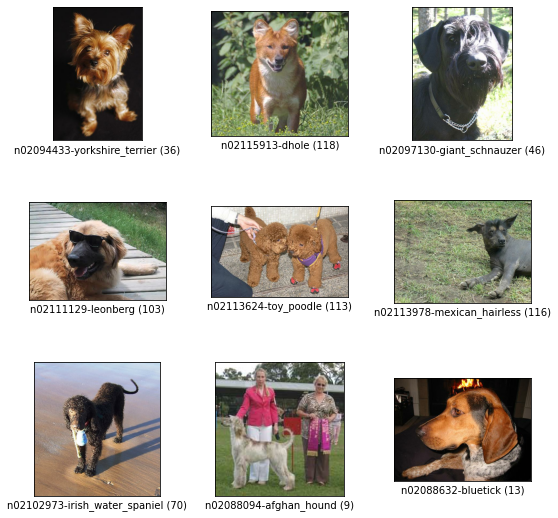

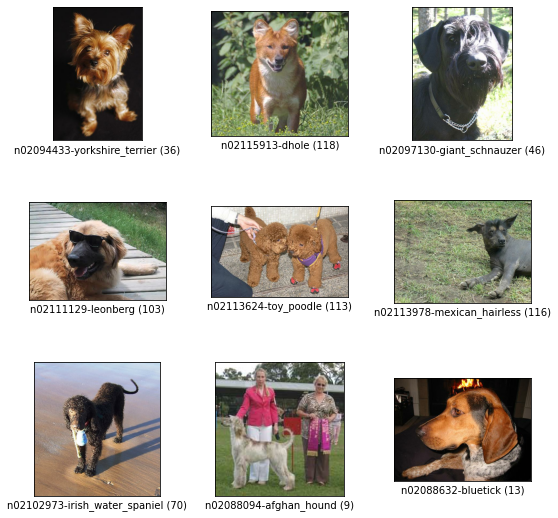

In [4]:
tfds.show_examples(ds_train, ds_info)

### (2) Augmentation 적용하기
- 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같음. 
- `random_brightness()`
- `random_contrast()`
- `random_crop()`
- `random_flip_left_right()`
- `random_flip_up_down`
- `random_hue()`
- `random_jpeg_quality()`
- `random_saturation()`

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

- `random_flip_left_right()`, `random_brightness()` 활용
- 이미지 분류 분제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않음. 
- 상하 대칭은 테스트 데이터셋의 이미지를 생각해볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것임. 
- brightness를 조절해 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 해보자. 

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

- Augmentation을 통해 원본 데이터셋을 다양한 형태로 가공한 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수를 `apply_normalize_on_dataset()`으로 정의
- normalize, resize, augmentation과 shuffle 적용
- shuffle이나 augmentation은 테스트 데이터셋에 적용하지 않도록 주의해야 함. 

### CutMix 함수 정의

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [8]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [9]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [10]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup 함수 정의

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [13]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

### 메인함수 정의

In [14]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

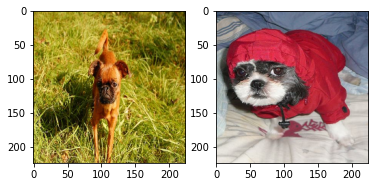

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

## (3) 비교실험
- augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능 비교
- 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델 로드
- `include_top`은 마지막 fc 레이어를 포함할지 여부임. 해당 레이어를 포함하지 않고 생성하면 feature extractor 부분만 불러와 우리의 필요에 맞게 수정된 fc 레이어를 붙여서 활용할 수 있음. 
- 이미지넷과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야하는 fc 레이어의 구조 또환 다르기 때문임. 

### no augmentation 모델

In [16]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 2s 0us/step


### 기본 augmentation 적용 모델

In [17]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

- 데이터셋에 불러온 데이터 중 하나는 `apply_normalize_on_dataset()`에서 `with_aug`를 `False`로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 `True`로 주어 augmentation이 적용되도록 함. 

### CutMix 적용 모델

In [18]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### Mixup 적용 모델

In [19]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

- 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행. 

In [21]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

In [22]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 106s 121ms/step - loss: 2.1850 - accuracy: 0.4469 - val_loss: 3.0853 - val_accuracy: 0.2563
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.6782 - accuracy: 0.8170 - val_loss: 1.1345 - val_accuracy: 0.6667
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1864 - accuracy: 0.9653 - val_loss: 0.9201 - val_accuracy: 0.7306
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0557 - accuracy: 0.9954 - val_loss: 0.9871 - val_accuracy: 0.7225
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0694 - accuracy: 0.9927 - val_loss: 1.0007 - val_accuracy: 0.7171
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0369 - accuracy: 0.9963 - val_loss: 0.9637 - val_accuracy: 0.7343
Epoch 7/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0124 - accuracy: 0.9994 - val_loss: 0.9611 - val_accuracy: 0.

In [23]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 98s 121ms/step - loss: 2.2846 - accuracy: 0.4288 - val_loss: 2.9114 - val_accuracy: 0.2801
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.9313 - accuracy: 0.7343 - val_loss: 1.7658 - val_accuracy: 0.5304
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.4759 - accuracy: 0.8708 - val_loss: 1.0102 - val_accuracy: 0.7020
Epoch 4/20
750/750 [==============================] - 90s 121ms/step - loss: 0.2436 - accuracy: 0.9455 - val_loss: 1.1162 - val_accuracy: 0.6790
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1509 - accuracy: 0.9690 - val_loss: 0.9897 - val_accuracy: 0.7182
Epoch 6/20
750/750 [==============================] - 92s 123ms/step - loss: 0.0738 - accuracy: 0.9899 - val_loss: 1.0766 - val_accuracy: 0.7076
Epoch 7/20
750/750 [==============================] - 92s 122ms/step - loss: 0.0446 - accuracy: 0.9953 - val_loss: 0.9444 - val_accuracy: 0.7

In [24]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 98s 122ms/step - loss: 3.8878 - accuracy: 0.1953 - val_loss: 3.4858 - val_accuracy: 0.1874
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 3.0355 - accuracy: 0.4037 - val_loss: 1.4458 - val_accuracy: 0.5940
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 2.7728 - accuracy: 0.4848 - val_loss: 1.2515 - val_accuracy: 0.6511
Epoch 4/20
750/750 [==============================] - 90s 121ms/step - loss: 2.5720 - accuracy: 0.5410 - val_loss: 1.1688 - val_accuracy: 0.6749
Epoch 5/20
750/750 [==============================] - 93s 125ms/step - loss: 2.4358 - accuracy: 0.5866 - val_loss: 1.1547 - val_accuracy: 0.6795
Epoch 6/20
750/750 [==============================] - 94s 125ms/step - loss: 2.3047 - accuracy: 0.6296 - val_loss: 1.2903 - val_accuracy: 0.6511
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2374 - accuracy: 0.6521 - val_loss: 1.2710 - val_ac

In [25]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 99s 122ms/step - loss: 3.7506 - accuracy: 0.2345 - val_loss: 3.6000 - val_accuracy: 0.1683
Epoch 2/20
750/750 [==============================] - 90s 121ms/step - loss: 2.9377 - accuracy: 0.4452 - val_loss: 1.6935 - val_accuracy: 0.5351
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 2.6734 - accuracy: 0.5472 - val_loss: 1.2949 - val_accuracy: 0.6362
Epoch 4/20
750/750 [==============================] - 94s 125ms/step - loss: 2.5132 - accuracy: 0.6080 - val_loss: 1.2559 - val_accuracy: 0.6510
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.3839 - accuracy: 0.6563 - val_loss: 1.2697 - val_accuracy: 0.6566
Epoch 6/20
750/750 [==============================] - 93s 123ms/step - loss: 2.2796 - accuracy: 0.6889 - val_loss: 1.5204 - val_accuracy: 0.5893
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 2.2222 - accuracy: 0.7178 - val_loss: 1.3021 - val_accuracy: 0.6

## (4) 훈련 과정 시각화

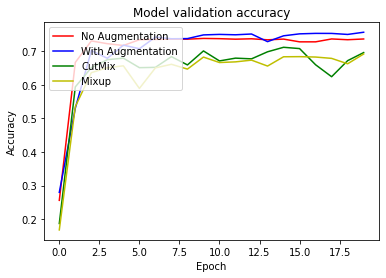

In [26]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

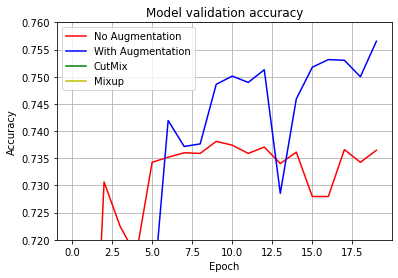

In [27]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당
plt.show()

## (5) 결과 분석
- Augmentation을 적용하거나 적용하지 않은 각 모델에 대해 20 EPOCHS씩 학습을 진행함. 
- 기대했던 것과 달리 CutMix, Mixup을 적용한 모델의 학습 결과가 No Augmentation 모델에 비해 더 좋지 않았음. 
- 기본 Augmentation만을 적용한 모델의 validation accuracy가 가장 높았음. 
- 이 실험의 경우 원본 데이터 없이 기본 Augmentation, CutMix, Mixup 기법이 적용된 변형된 데이터만을 모델에 넣었기 때문에 CutMix, Mixup 적용한 결과가 No Augmentation의 결과보다 validation accuracy가 낮게 나오지 않았나 추측됨. 